In [1]:
# importing libraries
import cv2
import numpy as np
import time

# importing libraries required for classification model

import PIL.Image as Image
import os
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd

In [2]:
# initializing weights and config files
scale = 0.00392
classes_file = "coco.names"
weights = "yolov4-tiny.weights"
config_file = "yolov4-tiny.cfg"

In [3]:
# reading classes from the coco dataset
classes = None
with open(classes_file, 'r') as file:
    classes = [line.strip() for line in file.readlines()]
classes[1]

'bicycle'

In [4]:
# initalizing colors array to generate different set of colors for bounding boxes
color = np.random.uniform(0, 255, size = (len(classes), 3))
color[0]

array([231.66393903, 123.20526049, 128.00226706])

In [5]:
#creating the dnn model
model = cv2.dnn.readNet(weights, config_file) 

'''
below method is used to detect objects in the frame. It accepts a frame and returns
the bounding box coordinates, classes of objects and confidence score for each object.
'''
def object_detection(frame):
    # getting width and height of the frame
    width = frame.shape[1]
    height = frame.shape[0]


    # creating input blob for the model
    blob = cv2.dnn.blobFromImage(frame, scale, (416,416), (0,0,0), True, crop=False)

    # passing input blob to the model
    model.setInput(blob)

    # getting output from the model for the blob passed
    output_layer = model.forward(model.getUnconnectedOutLayersNames())
    
    # initialization
    class_id_list = []
    confidences_list = []
    boxes_list = []
    conf_threshold = 0.5
    nms_threshold = 0.4

    # getting confidence, bounding box coordinates and class id from the output layers
    for out in output_layer:
        for result in out:
            scores = result[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5: # filtering boxes based on the confidence
                center_x = int(result[0] * width)
                center_y = int(result[1] * height)
                w = int(result[2] * width)
                h = int(result[3] * height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_id_list.append(class_id)
                confidences_list.append(float(confidence))
                boxes_list.append([x, y, w, h])
    
    # applying non-max suppression on the boxes generated
    index = cv2.dnn.NMSBoxes(boxes_list, confidences_list, conf_threshold, nms_threshold)
    
    # looping over the boxes remaining after nms 
    image_coordinates = []
    class_name = []
    confidence_score = []
    for i in index:
        i = i[0]
        box = boxes_list[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        
        # creating list of classes, coordinates and confidence score for each object detection
        class_name.append(str(classes[class_id_list[i]]))
        image_coordinates.append([round(x), round(y), round(x + w), round(y + h)])
        confidence_score.append(confidences_list[i])
    
    return image_coordinates, class_name, confidence_score

In [6]:
'''
this method is used to draw bounding boxes and label the car according to 
the output recieved from the classifier. This method accepts an image, labels, and coordinates
'''

def draw_bounding_box(img, label, confidence, x, y, w, h):
#     generating random number for color array
    id = np.random.randint(0, 75)
    colors = color[id]
    label = label + " confidence :" + str(round(confidence, 2))
    black = [255,255,255]
    # writing over the image
    cv2.rectangle(img, (x, y), (w, h), colors, 2)
    cv2.putText(img, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors, 2)

In [7]:
import pathlib
##changing the directory to a posix/linux path
data_dir = pathlib.Path()
data_dir

PosixPath('.')

In [8]:
## Do NOT RUN THIS CELL IF USING SAVED MODEL

# These dictionaries are used to read data from directory 
# and convert them to numpy array

car_images = {
    'sedan': list(data_dir.glob('Sedan/*')),
    'suv': list(data_dir.glob('SUV/*')),
    }
car_labels = {
    'sedan': 0,
    'suv': 1,
    }

In [9]:
## Do NOT RUN THIS CELL IF USING SAVED MODEL

# reading one file at the time and writing to X array
# and generating label for y 

X = []
y = []
for car, car_dir in car_images.items():
    for c in car_dir:
        try:
            img = cv2.imread(str(c))
            resize = cv2.resize(img, (224, 224))
            X.append(resize)
            y.append(car_labels[car])
        except Exception as e:
            pass

# converting arrays to numpy for faster operations
X = np.array(X)
y = np.array(y)

In [10]:
## Do NOT RUN THIS CELL IF USING SAVED MODEL

# splitting data into train and test for classification model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=None, shuffle = True)

In [11]:
## Do NOT RUN THIS CELL IF USING SAVED MODEL

# scaling the data 
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [12]:
keras_model = keras.models.load_model('model/')
# keras_model = None
if keras_model:
    print("Saved Model loaded")

else:
    print("Training the model")
    ## downloading the model from tensorflow hub website
    feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

    ## using only the pretrained weights from model
    pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

    car_types = 2

    ## defining the model required for classification
    keras_model = tf.keras.Sequential([
        pretrained_model_without_top_layer,
        tf.keras.layers.Dropout(
        rate = 0.3, input_shape = (None, 1280)
        ),
        tf.keras.layers.Dense(car_types)
    ])

    keras_model.summary()

    # compiling the model
    keras_model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    # training the model on X_train data with  epochs
    keras_model.fit(X_train_scaled, y_train, epochs=10)

Saved Model loaded


In [13]:
keras_model.save('model/')

INFO:tensorflow:Assets written to: model/assets


In [14]:
## Do NOT RUN THIS CELL IF USING SAVED MODEL

keras_model.evaluate(X_test_scaled, y_test)

17/17 [==============================] - 11s 549ms/step - loss: 0.4291 - accuracy: 0.8167


[0.42914119362831116, 0.8166666626930237]

In [25]:
'''
Below method can be used to detect objects in the video. It accepts a video 
on which detection is to be performed. It also generates a video of the detected
objects in each frame.
'''

def object_detection_Q1(video):
    frame_cnt = 1
    start_time = time.time()
    cap = cv2.VideoCapture(video) #reading the video
    frame_width = int(cap.get(3)) 
    frame_height = int(cap.get(4)) 
    size = (frame_width, frame_height)
    # creating object for writing frames to video
    result_ = cv2.VideoWriter('result_Q1.mp4', 
                        cv2.VideoWriter_fourcc(*'MP4V'), 
                        30, size)
    fps_list_q1 = []
    black = [0,0,0]
    # if frame is read correctly ret is True
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print(frame_cnt)
            print("Can't receive frame (stream end?). Exiting ...")
            break
        
        # running the object detection on frame
        image_coord, class_list, confidence = object_detection(frame)

        for i in range(len(class_list)):
            if class_list[i] == "car":
                try:      
                    ## cropping the detected object
                    x, y, w, h = image_coord[i][0], image_coord[i][1], image_coord[i][2], image_coord[i][3]

                    ## drawing the bounding boxes and label of the car
                    draw_bounding_box(frame, "", confidence[i],x, y, w, h)

                except Exception as e:
                    pass
        fps = round(frame_cnt / (time.time() - start_time), 2)
        cv2.putText(frame, "FPS : " + str(fps), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, black, 2)

        ## appending the result to the list
        frame_cnt += 1

        ## displaying every 100th image
        if(frame_cnt % 100 == 0):
            fps_ = round(frame_cnt / (time.time() - start_time), 2)
            fps_list_q1.append(fps_)
            plt.imshow(frame)
            plt.savefig("frame"+ str(i))
            plt.show()
        result_.write(frame)
        
    
    result_.release()
    cap.release()
    cv2.destroyAllWindows()
    print("Video saved successfully")
    throughput = round(900 / (time.time() - start_time), 2)
    print(f"Throughput of the system is {throughput}")
    
    return fps_list_q1

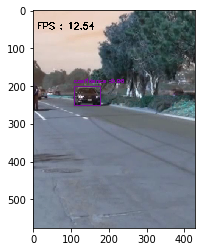

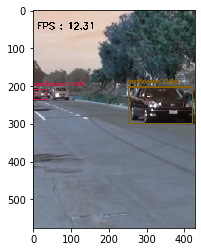

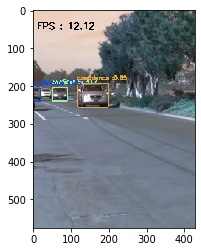

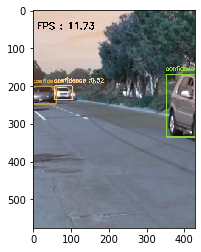

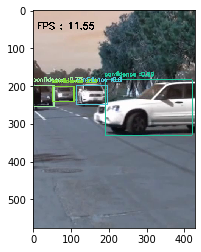

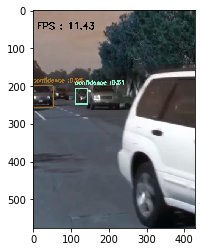

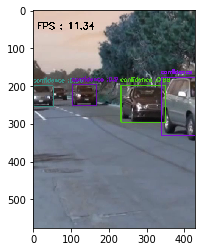

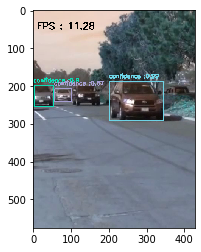

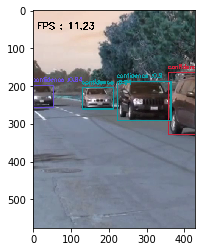

901
Can't receive frame (stream end?). Exiting ...
Video saved successfully
Throughput of the system is 11.18


In [26]:
vid = 'assignment-clip.mp4'
fps_list_Q1 = object_detection_Q1(vid)

In [17]:

'''
In this method, video is taken as an argument and object detection and classifcation
is performed. It outputs list of FPS per 100 frames. It also saves video of all frames
after detection and classification is performed.
'''
def object_classification_q2(video):


    fps_list_q2 = []
    last_time = time.time()

    # reading video using cv2
    cap = cv2.VideoCapture(video)

    frame_width = int(cap.get(3)) 
    frame_height = int(cap.get(4)) 
    size = (frame_width, frame_height)

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    # video_out = cv2.VideoWriter('output.mp4',fourcc, 20.0, (640,480))
    result_ = cv2.VideoWriter('output_q2.mp4', 
                            cv2.VideoWriter_fourcc(*'MP4V'), 
                            30, size)
    frame_count = 1
    final_result_list = []

    black = [0,0,0]
    while True:
        # reading frame-by-frame
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print(frame_count)
            print("Can't receive frame (stream end?). Exiting ...")
            break
        sedan = 0 
        suv = 0
        image_coord, class_list, confidence = object_detection(frame)
        cropped = None
        for i in range(len(class_list)):
            if class_list[i] == "car":
                try:            
                    ## cropping the detected object
                    x, y, w, h = image_coord[i][0], image_coord[i][1], image_coord[i][2], image_coord[i][3]
                    cropped_img = frame[y:h, x:w]
                    cropped_img = cv2.resize(cropped_img, (224, 224))
                    cropped_img = np.array([cropped_img])
                    cropped_img = cropped_img / 255

                    ## running through the classification model
                    result = keras_model.predict(cropped_img)
                    if np.argmax(result) == 0:
                        sedan += 1
                        label = "Sedan"
                    else:
                        suv += 1
                        label = "SUV"

                    ## drawing the bounding boxes and label of the car
                    draw_bounding_box(frame, label, confidence[i],x, y, w, h)

                except Exception as e:
                    pass
        fps = round(frame_count / (time.time() - last_time), 2)
        # writing FPS, total cars and car counts on the frame
        cv2.putText(frame, "FPS : " + str(fps), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, black, 2)
        cv2.putText(frame, "Total Cars : " + str(suv + sedan), (50, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, black, 2)
        cv2.putText(frame, "Sedan : " + str(sedan), (50, 450), 0, 1, black, 2)
        cv2.putText(frame, "SUV: " + str(suv), (50, 500), cv2.FONT_HERSHEY_SIMPLEX, 1, black, 2)

        ## appending the result to the list
        final_result_list.append([frame_count, sedan, suv, sedan+suv])
        frame_count += 1

        ## displaying every 100th image
        if(frame_count % 100 == 0):
            fps_ = round(frame_count / (time.time() - last_time), 2)
            fps_list_q2.append(fps_)
            plt.imshow(frame)
            plt.savefig("frame_Q2"+ str(i))
            plt.show()
        result_.write(frame)

    result_.release()
    cap.release()
    cv2.destroyAllWindows()
    print("Video saved successfully")
    throughput = round(900 / {time.time() - last_time}, 2)
    print(f"Throughput of the system is {throughput}")
    return fps_list_q2, final_result_list

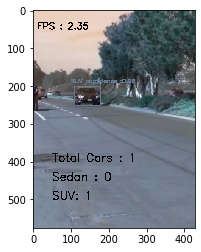

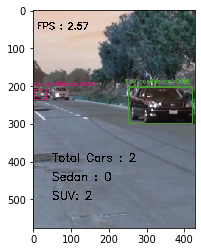

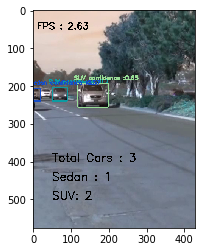

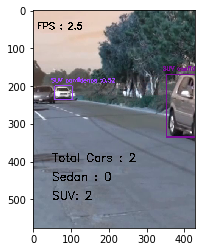

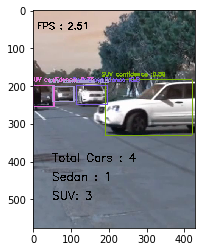

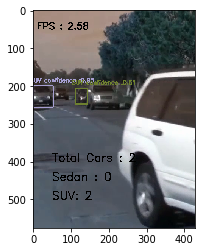

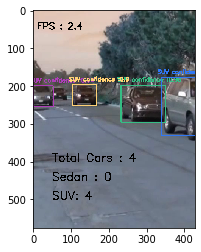

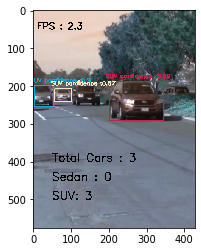

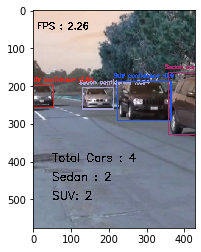

901
Can't receive frame (stream end?). Exiting ...
Video saved successfully
Total time taken 398.67729568481445


In [21]:
fps_list_Q2, final_result_list = object_classification_q2(vid)

In [20]:
#importing thread and queue for multithreading
from threading import Thread
import time
import random
from queue import Queue

global queue
queue = Queue(50)

# setting the width and height for the output video
cap = cv2.VideoCapture('assignment-clip.mp4')
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
size = (frame_width, frame_height)

#creating object for writing video back
result_ = cv2.VideoWriter('consumer_video.mp4', 
                        cv2.VideoWriter_fourcc(*'MP4V'), 
                        30, size)

fps_consumer = list()
start_time = time.time()

'''
Producer class is used to read frames and produce in the queue.
Producer and consumer class run in parallel using multi threading.
consumer class reads frames from the queue and performs object detection
and classification task.
'''
class Producer(Thread):
    global time_produce
    def run(self):
        frame_count_producer = 1
        cap = cv2.VideoCapture('assignment-clip.mp4') # reading video file
        print(f"starting producer \n")
        while(True):
            ret, frame = cap.read()
            if not ret:
                print("Can't receive frame (stream end?). Exiting ...")
                break
            queue.put(frame) # putting frames in the queue for consumer to consume
            
            frame_count_producer += 1
        

    
class Consumer(Thread):
    def run(self):
        global queue
        frame_count_consumer = 1
        black = [0, 0, 0]
        print(f"Starting consumer \n")
        while True:
            # count of sedan and suv class
            sedan = 0 
            suv = 0
            ## getting frames from the queue
            frame_consumer = queue.get()
            
            frame_count_consumer += 1
            
            ## running the frame through object detector model
            image_coord, class_list, confidence = object_detection(frame_consumer)
            cropped = None
            
            ## looping for all the objects detected in the frame
            for i in range(len(class_list)):
                if class_list[i] == "car":
                    try:
                        x, y, w, h = image_coord[i][0], image_coord[i][1], image_coord[i][2], image_coord[i][3]
                        cropped_queue = frame_consumer[y:h, x:w]
                        cropped_queue = cv2.resize(cropped_queue, (224, 224))
                        cropped_queue = np.array([cropped_queue])
                        cropped_queue = cropped_queue / 255

                        ## passing the cropped images to the classfier model
                        ## and labelling it sedan or suv
                        result = keras_model.predict(cropped_queue)
                        if np.argmax(result) == 0:
                            sedan += 1
                            label = "Sedan"
                        else:
                            suv += 1
                            label = "SUV"

                        # drawing bounding box and labelling the frame
                        draw_bounding_box(frame_consumer, label, confidence[i], x, y, w, h)

                    except Exception as e:
                        pass

            # calculating fps and writing other details on the frame
            fps = round(round(frame_count_consumer / (time.time() - start_time), 2), 2)
            cv2.putText(frame_consumer, "FPS : " + str(fps), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, black, 2)
            cv2.putText(frame_consumer, "Total Cars : " + str(suv + sedan), (50, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, black, 2)
            cv2.putText(frame_consumer, "Sedan : " + str(sedan), (50, 450), 0, 1, black, 2)
            cv2.putText(frame_consumer, "SUV: " + str(suv), (50, 500), cv2.FONT_HERSHEY_SIMPLEX, 1, black, 2)
            
            # writing each frame to the video writer object
            result_.write(frame_consumer)
            
            if(frame_count_consumer % 100 == 0):
                fps_ = round(frame_count_consumer / (time.time() - start_time), 2)
                fps_consumer.append(fps_)
            
            # stopping when all the frames are consumed
            if frame_count_consumer == 900:
                result_.release()
                cap.release()
                print("Video Saved")
                throughput = 900 / round(time.time() - start_time, 2)
                print(f"Throughput of the system is {throughput}")
                break

Producer().start()
Consumer().start()

Starting consumer 

starting producer 

Can't receive frame (stream end?). Exiting ...
Video Saved
Throughput of the system is 3.3545790003354576


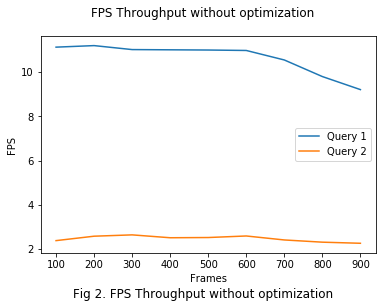

In [22]:
## plotting the fps from above
x_values = [100, 200, 300, 400, 500, 600, 700, 800, 900]
from matplotlib import pyplot as plt
plt.plot(x_values, fps_list_Q1, label = "Query 1")
plt.plot(x_values, fps_list_Q2, label = "Query 2")

plt.xlabel('Frames')
plt.ylabel('FPS')
plt.legend()

plt.figtext(0.5, -0.03, "Fig 2. FPS Throughput without optimization", wrap=True, horizontalalignment='center', fontsize=12)

plt.suptitle("FPS Throughput without optimization")
plt.savefig("fps_throughput.jpeg")
plt.show()

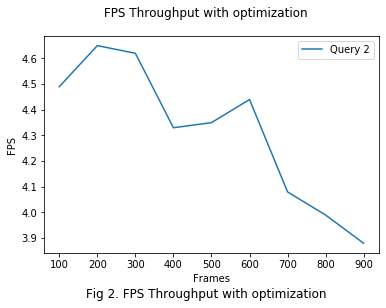

In [34]:
## plotting the fps from above
x_values = [100, 200, 300, 400, 500, 600, 700, 800, 900]
from matplotlib import pyplot as plt
plt.plot(x_values, fps_consumer, label = "Query 2")

plt.xlabel('Frames')
plt.ylabel('FPS')
plt.legend()

plt.figtext(0.5, -0.03, "Fig 2. FPS Throughput with optimization", wrap=True, horizontalalignment='center', fontsize=12)

plt.suptitle("FPS Throughput with optimization")
plt.savefig("fps_throughput_consumer.jpeg")
plt.show()

In [22]:
ground_truth = pd.read_csv('Groundtruth.csv', encoding='utf-8')
ground_truth.head()

,Frame#,Sedan,SUV,Total
0,1,2,1,3
1,2,2,1,3
2,3,2,1,3
3,4,2,1,3
4,5,2,1,3


In [23]:
df = pd.DataFrame(final_result_list)
df.columns = ['Frame', 'Sedan', 'SUV', 'Total']
df.head()

,Frame,Sedan,SUV,Total
0,1,1,2,3
1,2,0,2,2
2,3,0,2,2
3,4,1,2,3
4,5,1,2,3


In [41]:
'''
calculating F1 score for total cars predicted in the frame.
'''

y_true = ground_truth['Total'].values
y_pred = df['Total'].values
fscore_total = []
for i in range(len(y_true)):
    precision = 1
    if y_pred[i] > y_true[i]:
        recall = 1
    else:
        recall = y_pred[i] / y_true[i]
    fscore = 2 * ((precision * recall) / (precision + recall))
    fscore_total.append(fscore)
    
print(f"F1 score for Q1 is {round(np.mean(fscore_total), 2)}")

F1 score for Q1 is 0.87


In [40]:
'''
calculating F1 score for Q2.
'''

tp = fp = fn = 0
suv_pred = df['SUV'].values
sedan_pred = df['Sedan'].values
y_suv = ground_truth['SUV'].values
y_sedan = ground_truth['Sedan'].values
#precision = tp / (tp + fp)
# y_pred = (tp + fp)
#recall = tp / (tp + fn)
fscore_list = []
for i in range(900):
    tp = sum([min(suv_pred[i], y_suv[i]), min(sedan_pred[i], y_sedan[i])])
    fp = max(0, y_sedan[i] - sedan_pred[i])
    fn = max(0, y_suv[i] - suv_pred[i])
    if tp == 0 and fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    if tp == 0 and fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    if precision == 0 and recall == 0:
        fscore = 0
    else:
        fscore = 2 * ((precision * recall) / (precision + recall))
    fscore_list.append(fscore)
    
print(f"F1 score for Q2 is {round(np.mean(fscore_list), 2)}")

F1 score for Q2 is 0.7


In [26]:
df.to_csv('predictions.csv', index=False)